In [14]:
%load_ext autoreload
%autoreload 0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
from functools import partial

import gymnasium as gym
import numpy as np
import seaborn as sns
import torch as t
from gymnasium import wrappers
from gymnasium.envs.registration import EnvSpec
from matplotlib import pyplot as plt
from rich.pretty import pprint as pp
from tqdm import tqdm

from bert_sac.gymnasium_envs import ants
from bert_sac.models import Actor, SoftQNetwork
from bert_sac.sac_trainer import AntSAC, AntSACConfig
from bert_sac.utils import make_env

ppe = partial(pp, expand_all=True)

SEED = 999

device = t.device("cuda:0")
t.set_default_device(device)

In [16]:
att_mask = [
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0],
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0],
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0],
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0],
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0],
    [1] * 7 + [0] * 6 + [1] * 8 + [0] * 4,
    [1] * 5 + [0] * 2 + [1] * 2 + [0] * 4 + [1] * 6 + [0] * 2 + [1] * 2 + [0] * 2,
    [1] * 5 + [0] * 4 + [1] * 2 + [0] * 2 + [1] * 6 + [0] * 4 + [1] * 2,
    [1] * 5 + [0] * 6 + [1] * 2 + [0] * 0 + [1] * 6 + [0] * 6,
    [0] * 5 + [1] * 2 + [0] * 12 + [1] * 2 + [0] * 4,
    [0] * 7 + [1] * 2 + [0] * 12 + [1] * 2 + [0] * 2,
    [0] * 9 + [1] * 2 + [0] * 12 + [1] * 2,
    [0] * 11 + [1] * 2 + [0] * 12,
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0],
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0],
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0],
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0],
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0],
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0],
    [1] * 7 + [0] * 6 + [1] * 8 + [0] * 4,
    [1] * 5 + [0] * 2 + [1] * 2 + [0] * 4 + [1] * 6 + [0] * 2 + [1] * 2 + [0] * 2,
    [1] * 5 + [0] * 4 + [1] * 2 + [0] * 2 + [1] * 6 + [0] * 4 + [1] * 2,
    [1] * 5 + [0] * 6 + [1] * 2 + [0] * 0 + [1] * 6 + [0] * 6,
    [0] * 5 + [1] * 2 + [0] * 12 + [1] * 2 + [0] * 4,
    [0] * 7 + [1] * 2 + [0] * 12 + [1] * 2 + [0] * 2,
]
np.array(att_mask)

array([[1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 0],
       [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 0],
       [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 0],
       [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 0],
       [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 0],
       [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        1, 0, 0],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 1, 1],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
      

{'ATT_MASK.shape': torch.Size([25, 25])}

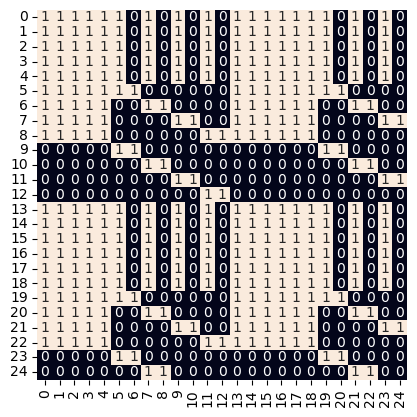

In [17]:
NUM_STRUCT_ELEMENTS = 7

ATT_MASK = t.tensor(
    [
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
    ]
)

pp({"ATT_MASK.shape": ATT_MASK.shape})

sns.heatmap(ATT_MASK.cpu(), square=True, cbar=False, annot=True)
plt.show()


In [23]:
envs = gym.vector.AsyncVectorEnv([make_env("Ant-v4", seed=SEED) for _ in range(4)])

In [28]:
env = gym.make("Ant-v4")
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<AntEnv<Ant-v4>>>>>

In [38]:
from bert_sac.gymnasium_envs.ants import AntLegsEnv

In [41]:
ant_env = AntLegsEnv()
ant_env

In [42]:
wrappers.TimeLimit(ant_env, 1000)

<TimeLimit<AntLegsEnv instance>>